In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'mobysound_humpback_whale'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=1,
    mel_upper_edge_hertz=1995,
    butter_lowcut = 1,
    butter_highcut = 1995,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 100,
    hop_length_ms = 20,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.25, "offset": 1e-10},
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 1.5, "prop_decrease":0.9}

)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [9]:
#dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [10]:
dataset.sample_json

OrderedDict([('bout_number', 13),
             ('datetime', '1994-03-05_09-21-00'),
             ('samplerate_hz', 4000),
             ('length_s', 251.85775),
             ('wav_loc',
              '/mnt/cube/Datasets/mobysound/humpback-01/940305-0921.wav'),
             ('noise_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/mobysound_humpback_whale/2019-06-23_20-56-52/NOISE/940305-0921__h0m0s0.0.WAV'),
             ('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [15.0,
                                                         18.68000030517578,
                                                         26.969999313354492,
                                                         31.75,
                                                         34.04999923706055,
           

In [11]:
len(dataset.data_files)

14

#### Create dataset based upon JSON

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["SNR"],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    4.9s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    5.0s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    5.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    5.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    5.2s finished


2310

In [14]:
syllable_df[:3]

start_time   end_time        SNR indv  indvi          key
0   15.000000  18.020000  20.783400  UNK      0  940305-0921
1   18.680000  25.760000  29.786501  UNK      0  940305-0921
2   26.969999  29.389999  33.075901  UNK      0  940305-0921

### get audio for dataset

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    4.8s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    5.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    6.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    9.4s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    9.9s finished


2310

In [16]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [17]:
syllable_df = syllable_df[np.array(df_mask)]

In [18]:
syllable_df[:3]

start_time   end_time        SNR indv  indvi          key  \
0   15.000000  18.020000  20.783400  UNK      0  940305-0921   
1   18.680000  25.760000  29.786501  UNK      0  940305-0921   
2   26.969999  29.389999  33.075901  UNK      0  940305-0921   

                                               audio  rate  
0  [2.7205797e-05, 0.0005613247, 0.00064735615, -...  4000  
1  [-0.0010261064, 0.00046434964, -0.0011873896, ...  4000  
2  [0.00070088793, 0.0011319447, -0.0005567992, -...  4000

In [19]:
sylls = syllable_df.audio.values

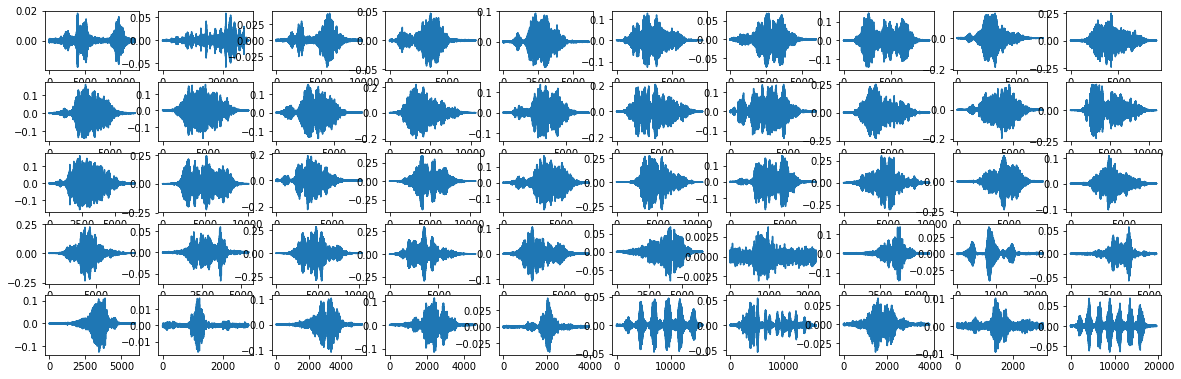

In [20]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [21]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [22]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [23]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0710s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0363s.) Setting batch_size=44.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1336s.) Setting batch_size=130.
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.4s


[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2310 out of 2310 | elapsed:    1.3s finished


### Rescale spectrogram
- using log rescaling

In [25]:
log_scaling_factor = 4

In [26]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0103s.) Setting batch_size=38.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1387s.) Setting batch_size=108.
[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:    0.2s


[Parallel(n_jobs=-1)]: Done 2310 out of 2310 | elapsed:    3.4s finished


(25.0, 10) (320, 800) 25.0 32 800


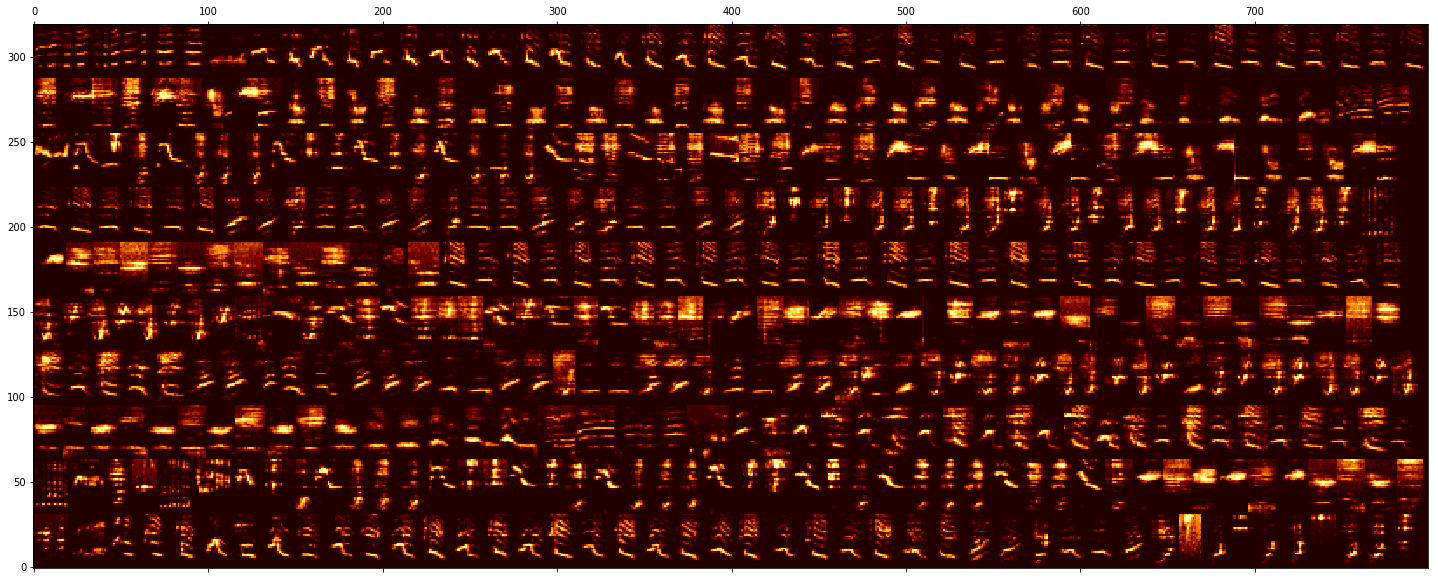

In [27]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Mask/threshold spectrograms to remove noise

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0100s.) Setting batch_size=38.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1651s.) Setting batch_size=92.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.2s


(25.0, 10) (320, 800) 25.0 32 800


[Parallel(n_jobs=-1)]: Done 2310 out of 2310 | elapsed:    0.4s finished


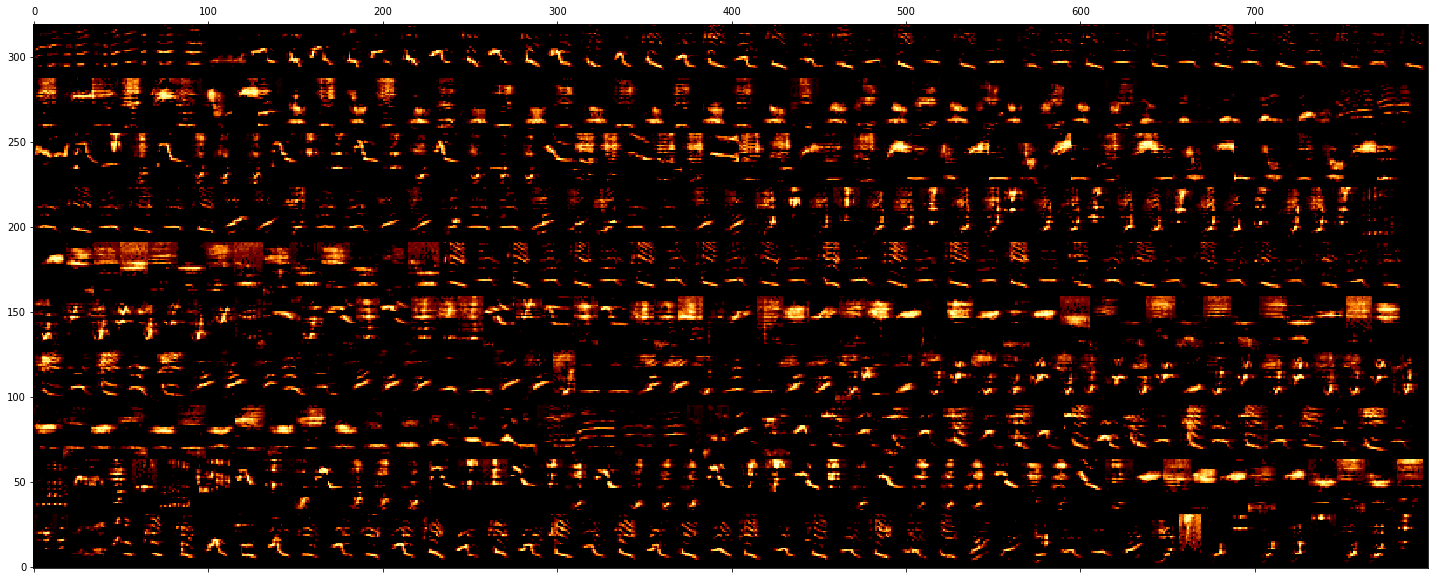

In [28]:
if hparams.mask_spec:
    with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
        # Mask spectrograms
        if dataset.hparams.mask_spec:
            syllables_spec = parallel(
                delayed(mask_spec)(syllable, **dataset.hparams.mask_spec_kwargs)
                for syllable in tqdm(
                    syllables_spec,
                    total=len(syllables_rate),
                    desc="masking spectrograms",
                    leave=False,
                )
            )
    draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [29]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [30]:
syllable_df[:3]

start_time   end_time        SNR indv  indvi          key  \
0   15.000000  18.020000  20.783400  UNK      0  940305-0921   
1   18.680000  25.760000  29.786501  UNK      0  940305-0921   
2   26.969999  29.389999  33.075901  UNK      0  940305-0921   

                                               audio  rate  
0  [0.0014929071, 0.030802466, 0.035523407, -0.02...  4000  
1  [-0.017301673, 0.007829622, -0.020021146, -0.0...  4000  
2  [0.016452115, 0.026570419, -0.013069885, -0.01...  4000

In [31]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


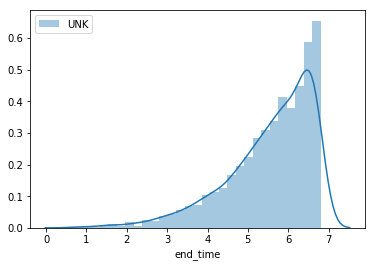

In [32]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [33]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0507s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0676s.) Setting batch_size=82.


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 407 out of 2310 | elapsed:    0.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 2310 out of 2310 | elapsed:    0.6s finished


(25.0, 10) (320, 800) 25.0 32 800


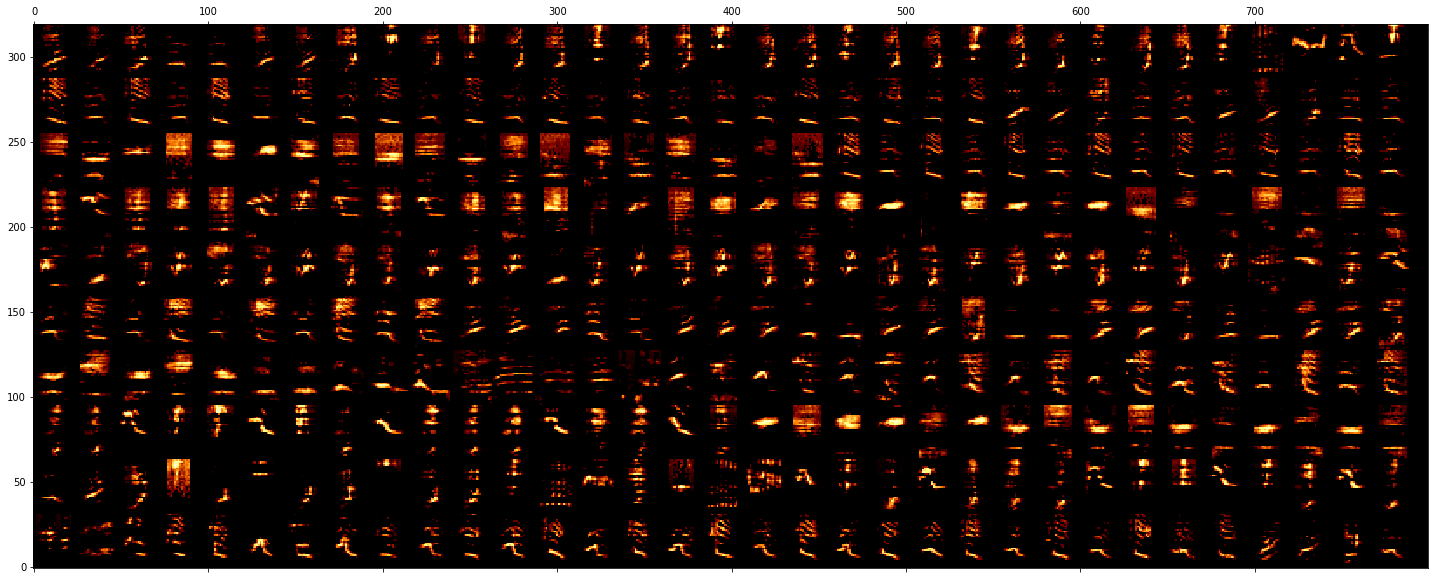

In [34]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [35]:
np.shape(syllables_spec)

(2310, 32, 24)

In [36]:
syllable_df['spectrogram'] = syllables_spec

In [37]:
syllable_df[:3]

start_time   end_time        SNR indv  indvi          key  \
0   15.000000  18.020000  20.783400  UNK      0  940305-0921   
1   18.680000  25.760000  29.786501  UNK      0  940305-0921   
2   26.969999  29.389999  33.075901  UNK      0  940305-0921   

                                               audio  rate  \
0  [0.0014929071, 0.030802466, 0.035523407, -0.02...  4000   
1  [-0.017301673, 0.007829622, -0.020021146, -0.0...  4000   
2  [0.016452115, 0.026570419, -0.013069885, -0.01...  4000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

### view syllables per indv

In [38]:
syllable_df.indv.unique()

array(['UNK'], dtype=object)

UNK 2310
(50.0, 32) (512, 800) 25.0 32 800


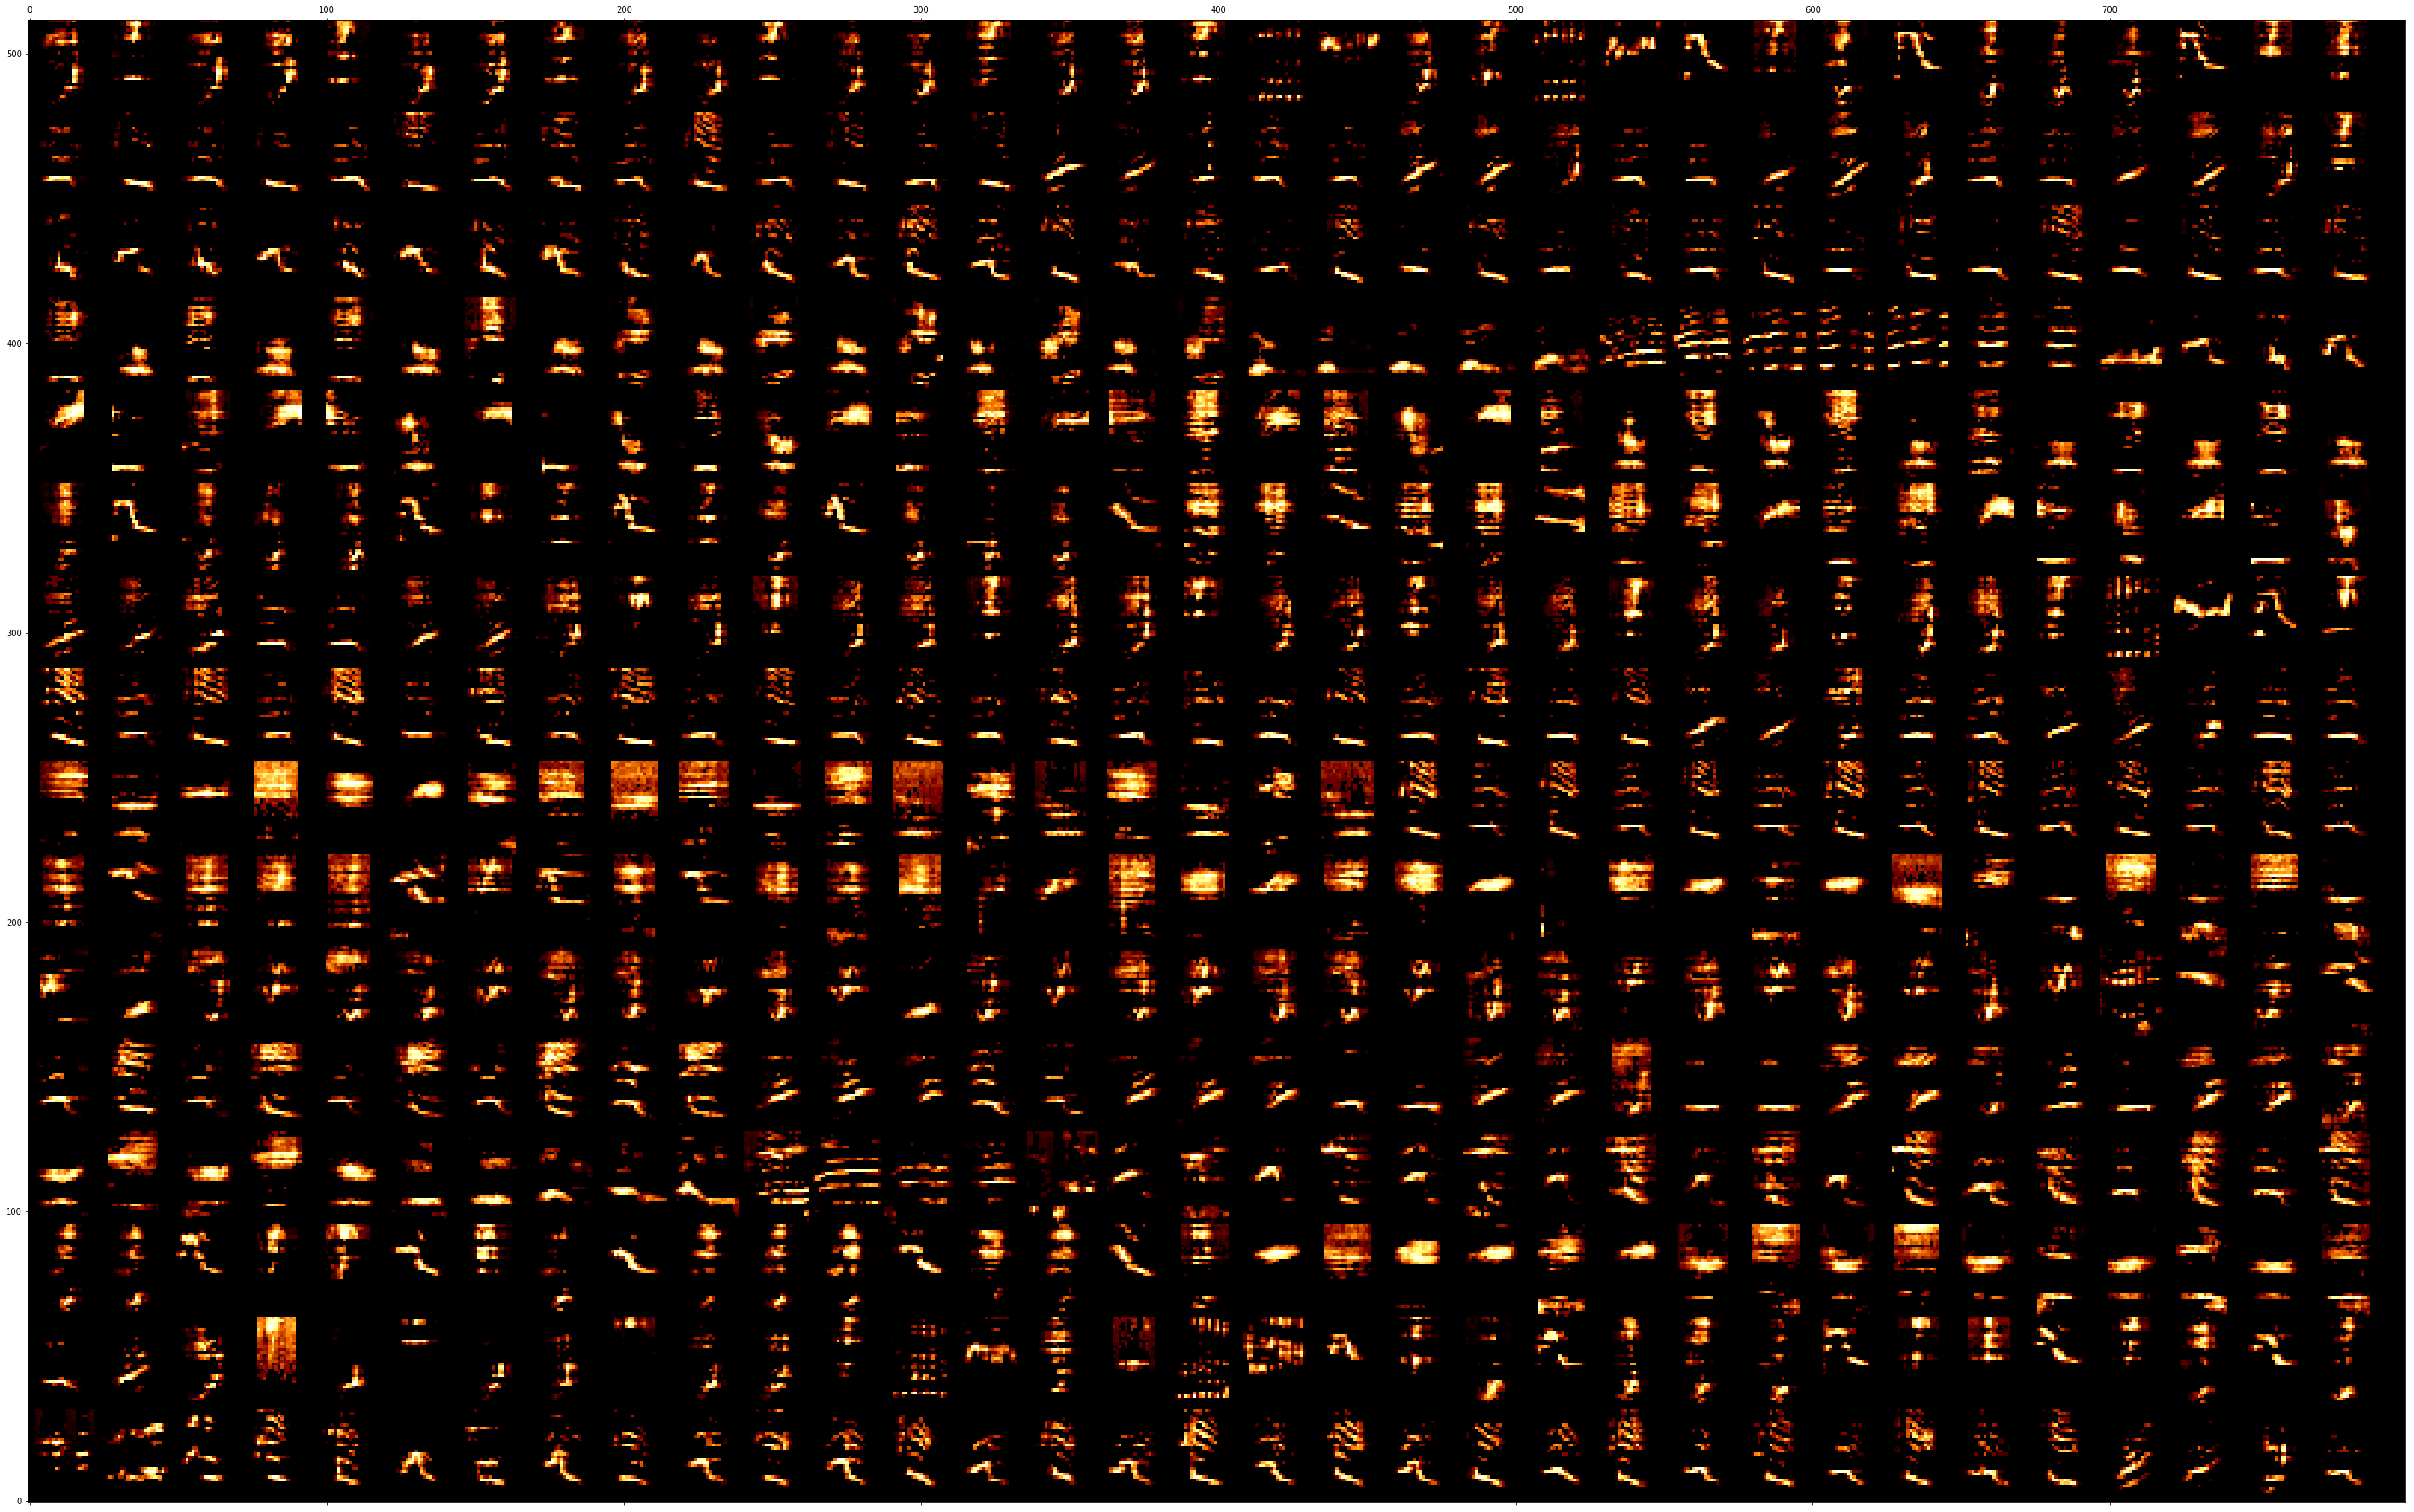

In [39]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [40]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'humpback.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)